author: spe

This example covers calculating the forces in a one-dimensional lambda
enhanced cooling, as in PRA 87 063411 (2013).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
#from pylcp.common import printProgressBar
import pylcp.tools
import time
plt.style.use('paper')


Let's define the three level problem just as we did in the basic example.

In [2]:
# First, define the lasers (functionalized for later):
def return_three_level_lasers(Ige, Ire):
    laserBeams = {}
    laserBeams['g->e'] = pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':0., 'beta':Ige},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':0., 'beta':Ige}])
    laserBeams['r->e'] = pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':0., 'beta':Ire},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':0., 'beta':Ire}
        ])
    return laserBeams

# Second, magnetic field:
magField = lambda R: np.zeros(R.shape)

# Now define the Hamiltonian (functionaized for later):
H0 = np.array([[1.]])
mu_q = np.zeros((3, 1, 1))
d_q = np.zeros((3, 1, 1))
d_q[1, 0, 0,] = 1/np.sqrt(2)

def return_three_level_hamiltonian(Delta, delta):
    hamiltonian = pylcp.hamiltonian()
    hamiltonian.add_H_0_block('g', 0.*H0)
    hamiltonian.add_H_0_block('r', delta*H0)
    hamiltonian.add_H_0_block('e', Delta*H0)
    hamiltonian.add_d_q_block('g','e', d_q)
    hamiltonian.add_d_q_block('r','e', d_q)

    return hamiltonian

hamiltonian = return_three_level_hamiltonian(-5., 1.)
hamiltonian.print_structure()


[[(<g|H_0|g> 1x1) None (<g|d_q|e> 1x1)]
 [None (<r|H_0|r> 1x1) (<r|d_q|e> 1x1)]
 [(<e|d_q|g> 1x1) (<e|d_q|r> 1x1) (<e|H_0|e> 1x1)]]


Let's look at an individual solution first:

In [3]:
laserBeams = return_three_level_lasers(2*3.4**2, 0.02*2*3.4**2)
hamiltonian = return_three_level_hamiltonian(4.5, 0.1)

obe.set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                      np.array([1.0, 0., 0.]))
obe.set_initial_rho_equally()
obe.evolve_density([0, 2*np.pi*100])
f, f_laser, f_laser_q = obe.force_from_sol(return_q=True)
(t, rho) = obe.reshape_sol()

fig, ax  = plt.subplots(1, 2, figsize=(6.25, 2.75))
ax[0].plot(t, rho[0, 0])
ax[0].plot(t, rho[1, 1])
ax[0].plot(t, rho[2, 2])

ax[1].plot(t, f_laser['g->e'][0][0], linewidth=0.5)
ax[1].plot(t, f_laser['g->e'][0][1], linewidth=0.5)

ax[1].plot(t, f_laser['r->e'][0][0], linewidth=0.5)
ax[1].plot(t, f_laser['r->e'][0][1], linewidth=0.5)


NameError: name 'obe' is not defined

Rather than making a force profile, we are first going to solve at small
velocities and determine the damping coefficent, to compare to Fig. 4/6.  Note
that they fix $\Delta_2$ and change $\Delta_1$ and that $\Delta_2$ is the strong

In [4]:
Delta2 = 4.5
deltas = np.arange(-9., 6., 0.1)
Delta1s = Delta2 + deltas
Ires = np.array([2*3.4**2, 2*2.1**2])
Iges = 0.02*Ires

dv = 0.005

alphas = []
for (Ige, Ire) in zip(Iges, Ires):
    it = np.nditer([deltas, Delta1s, None, None])
    tic = time.time()
    for (delta, Delta1, alpha, iterations) in it:
        laserBeams = return_three_level_lasers(Ige, Ire)
        hamiltonian = return_three_level_hamiltonian(Delta1, delta)

        obe = pylcp.obe(laserBeams, magField, hamiltonian,
                            transform_into_re_im=True)

        obe.set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                              np.array([dv, 0., 0.]))
        obe.set_initial_rho_equally()
        ans = obe.find_equilibrium_force(deltat=2*np.pi*1000, itermax=50)
        alpha[...] = -ans[0][0]/dv
        iterations[...] = ans[-1]

        avgtime = (time.time()-tic)/(it.iterindex+1)
        printProgressBar(it.iterindex+1, it.itersize, prefix = 'Progress:',
                         suffix = 'complete', decimals = 1, length = 40,
                         remaining_time = (it.itersize-it.iterindex)*avgtime)

    alphas.append(it.operands[2])

fig, ax = plt.subplots(1, 1)
for ii, alpha in enumerate(alphas):
    ax.plot(deltas, alpha, label='$\Omega_2=%.2f$' % np.sqrt(Ires[ii]/2),
            linewidth=0.75)
ax.set_xlabel('$\\delta/\Gamma$')
ax.set_ylabel('$\\alpha/\hbar k^2$')
ax.legend(fontsize=8)

#fig.savefig('lambda_enhanced_cooling_alpha.pdf')


NameError: name 'printProgressBar' is not defined

Let's take a look at force profiles like Fig. 7.  They divide by the thermal
velocity at 200 uK rather than the Doppler velocity.  So the first step is to f
figure out what the thermal velocity actually is:

import scipy.constants as cts
Li = pylcp.atom.atom('7Li')
vLi = np.sqrt(cts.k*200e-6/Li.mass)/(Li.transition[1].lam/2/np.pi*Li.state[2].gamma)

That works out to be 0.12.  Then the ranges of th plots are 4 times that.  I
think there might be a factor of 2 I am missing somewhere.


Completed in 22:40.                                                 
Completed in 23:11.                                                 
Completed in 12:02.                                                 
Completed in 16:14.                                                 
Completed in 14:40.                                                 
Completed in 33:36.                                                 


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


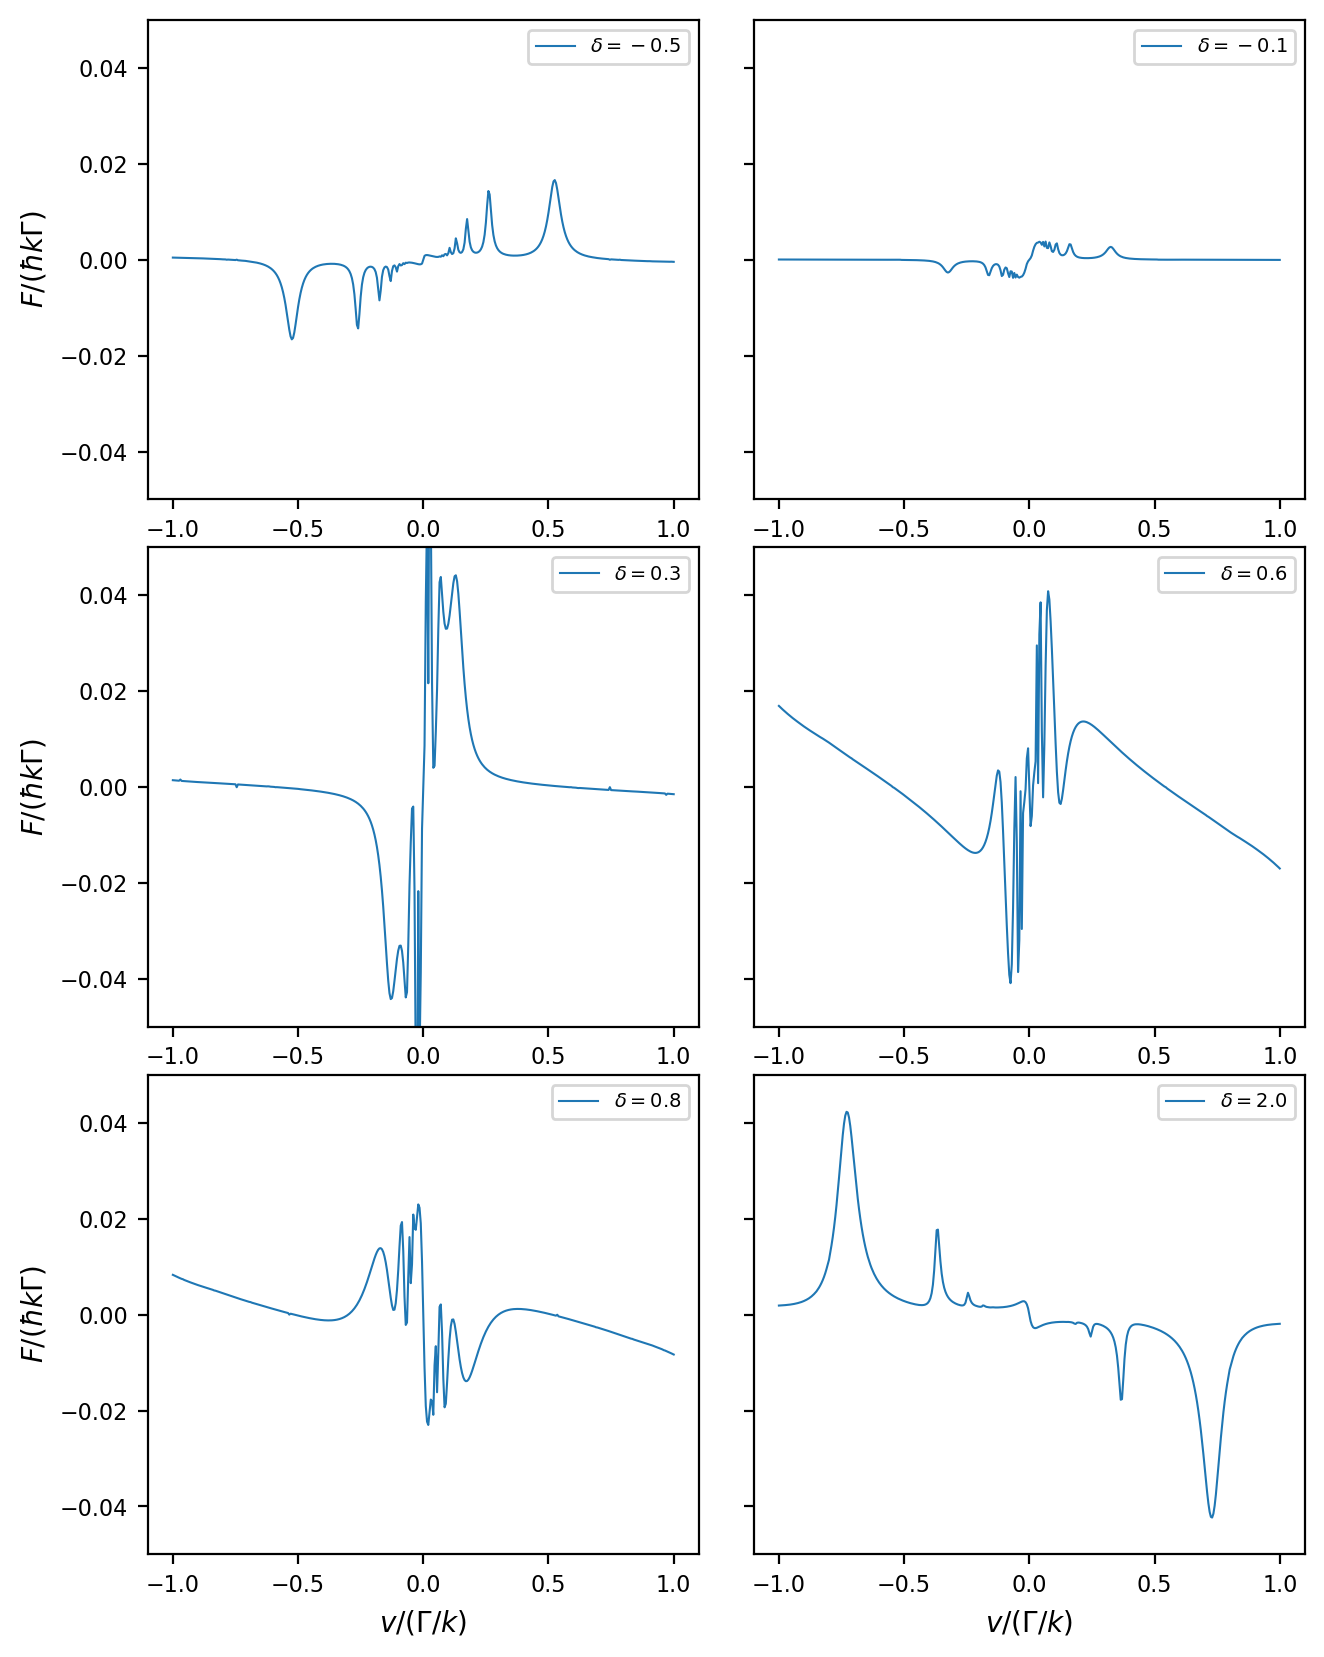

In [5]:
Delta2 = 4.5
deltas = np.array([-0.5, -0.1, 0.3, 0.6, 0.8, 2.0])
Delta1s = Delta2 + deltas
Ire = 2*3.4**2
Ige = 0.02*Ire

obe = {}
v = np.arange(-1, 1.005, 0.005)
for Delta1, delta in zip(Delta1s, deltas):
    laserBeams = return_three_level_lasers(Ige, Ire)
    hamiltonian = return_three_level_hamiltonian(Delta1, delta)

    obe[delta] = pylcp.obe(laserBeams, magField, hamiltonian,
                        transform_into_re_im=True)

    obe[delta].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [v, np.zeros(v.shape), np.zeros(v.shape)],
        name='molasses', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=2000,
        rel=1e-8, abs=1e-10, progress_bar=True, initial_rho='equally'
    )
    obe[delta].laserBeams['g->e'].beam_vector[1].kvec
    obe[delta].profile['molasses'].f['g->e'].shape

fig, ax = plt.subplots(3, 2, figsize=(6.5, 2.75*3))
for ii, delta in enumerate(deltas):
    ax[int(ii/2), ii%2].plot(v, obe[delta].profile['molasses'].F[0], '-',
                             linewidth=0.75, label='$\delta=%.1f$'%delta)
    ax[int(ii/2), ii%2].legend(fontsize=7)
    ax[int(ii/2), ii%2].set_ylim((-0.05, 0.05))
[ax_i.set_xlabel('$v/(\Gamma/k)$') for ax_i in ax[-1, :]]
[ax_i.set_ylabel('$F/(\hbar k \Gamma)$') for ax_i in ax[:, 0]]
[ax_i.set_yticklabels([]) for ax_i in ax[:, 1]]
fig.subplots_adjust(left=0.09, bottom=0.05)
#fig.savefig('lambda_enhanced_cooling_force_profiles.pdf')
